<a href="https://colab.research.google.com/github/victormurcia/Simple-OCR/blob/main/OCR_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import numpy as np
import re

#Enable data to be extracted from my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


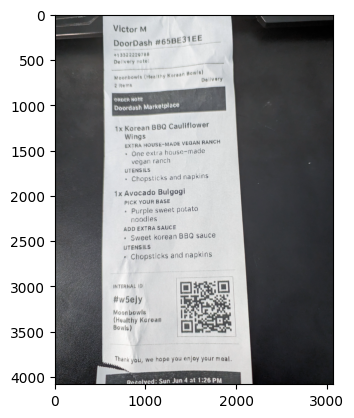

In [102]:
image = cv2.imread('/content/drive/MyDrive/receipt.jpg')

# Display the image
plt.imshow(image)
plt.axis('on')  # Remove axis ticks and labels

# Show the plot
plt.show()

In [92]:
# Get the size of the image
height, width, channels = image.shape
print(height, width, channels)

4080 3072 3


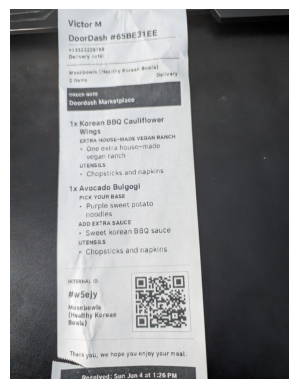

In [93]:
# Define the new dimensions
new_width = int(0.5 * width)
new_height =int(0.5 * height)

# Resize the image
resized_image = cv2.resize(image, (new_width, new_height))

# Display the image
plt.imshow(resized_image)
plt.axis('off')  # Remove axis ticks and labels

# Show the plot
plt.show()

In [94]:
# Get the size of the image
height, width, channels = resized_image.shape
print(height, width, channels)

2040 1536 3


In [95]:
# Convert BGR to RGB
recolored_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

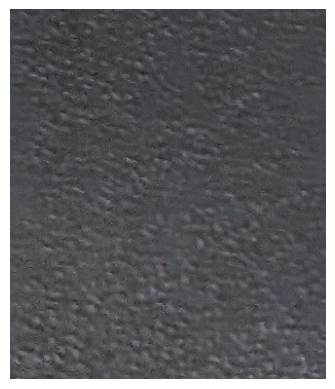

In [96]:
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 0, 275)

# Find contours of the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Find the bounding rectangle of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the image
cropped_image = image[y:y+h, x:x+w]

# Display the image
plt.imshow(cropped_image)
plt.axis('off')  # Remove axis ticks and labels

# Show the plot
plt.show()

Number of contours: 2704


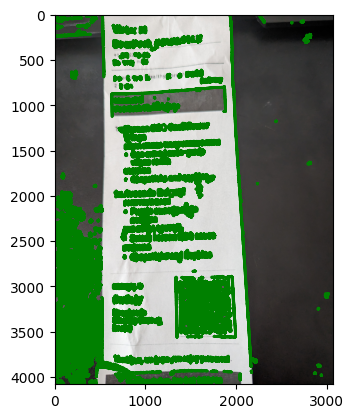

In [97]:
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, 250, 255,apertureSize=3)

# Print the number of contours found
print("Number of contours:", len(contours))

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Draw the contours on the axes
for contour in contours:
    ax.plot(contour[:, 0, 0], contour[:, 0, 1], 'g', linewidth=2)

# Set the aspect ratio
ax.set_aspect('equal')

# Show the plot
plt.show()

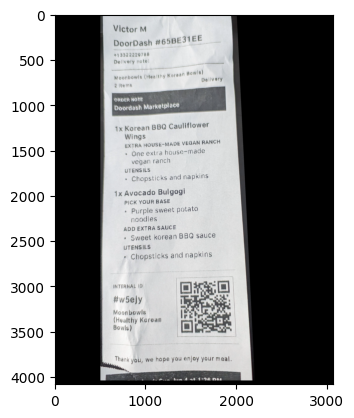

In [101]:
# Create an empty mask with zeros, same size as the image
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Define the region of interest (ROI) vertices
roi_vertices = np.array([[(500, 4040), (500, 0), (2000, 0), (2200, 4040)]], dtype=np.int32)

# Draw the ROI polygon on the mask as white (255)
cv2.fillPoly(mask, roi_vertices, 255)

# Apply the mask to the image using bitwise AND operation
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image with filtered contours
ax.imshow(masked_image)

# Remove axis ticks and labels
ax.axis('on')

# Show the plot
plt.show()

Number of contours: 1766


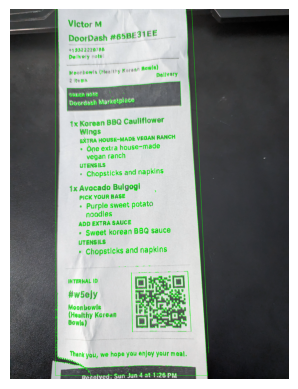

In [99]:
# Convert the masked image to grayscale
gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 100, 255)

# Find contours of the edges within the ROI
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Print the number of contours found
print("Number of contours:", len(contours))

# Draw the contours on the original image
output_image = image.copy()
cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image with the extracted contours within ROI
ax.imshow(output_image)

# Remove axis ticks and labels
ax.axis('off')

# Show the plot
plt.show()

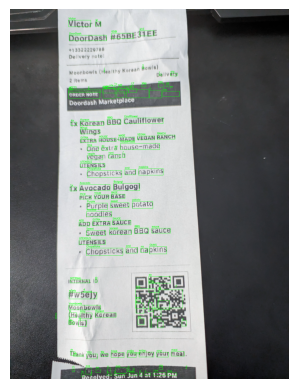

In [145]:
# Create an empty mask with zeros, same size as the image
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Define the region of interest (ROI) vertices
roi_vertices = np.array([[(500, 4040), (500, 0), (2000, 0), (2200, 4040)]], dtype=np.int32)

# Draw the ROI polygon on the mask as white (255)
cv2.fillPoly(mask, roi_vertices, 255)

# Apply the mask to the image using bitwise AND operation
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Convert the masked image to grayscale
gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

# Perform OCR on the grayscale image within the ROI
custom_config = r'--oem 3 --psm 6'  # Custom configuration for Tesseract
results = pytesseract.image_to_data(gray, lang='eng', config=custom_config, output_type=Output.DICT)

# Define a regular expression pattern to filter out undesired text regions
pattern = r'^[a-zA-Z0-9]+$'

# Extract the text regions and their corresponding bounding boxes, excluding undesired patterns
text_regions = []
for i, text in enumerate(results['text']):
    cleaned_text = re.sub(r'[^a-zA-Z0-9]', '', text)
    if re.match(pattern, cleaned_text):
        x, y, w, h = results['left'][i], results['top'][i], results['width'][i], results['height'][i]
        text_regions.append((cleaned_text, (x, y, w, h)))

# Draw bounding boxes and text on the original image
output_image = image.copy()
for text, (x, y, w, h) in text_regions:
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(output_image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
  
# Create a figure and axes
fig, ax = plt.subplots()
# Display the image with the extracted contours within ROI
ax.imshow(output_image)
# Remove axis ticks and labels
ax.axis('off')
# Show the plot
plt.show()

In [131]:
# Print the extracted text
#for text, _ in cleaned_text_regions:
#    print(text)

In [143]:
len(text_regions)

127

In [144]:
text_regions

[('Victor', (645, 123, 244, 73)),
 ('M', (942, 141, 58, 47)),
 ('DoorDash', (652, 289, 410, 61)),
 ('65BI', (1116, 267, 242, 60)),
 ('s1E', (1427, 239, 159, 57)),
 ('2', (1455, 641, 21, 15)),
 ('j', (1035, 678, 4, 18)),
 ('r', (1640, 715, 27, 18)),
 ('ary', (1767, 707, 74, 31)),
 ('r', (663, 884, 6, 7)),
 ('x', (859, 877, 13, 11)),
 ('vps', (1043, 869, 23, 13)),
 ('pte', (1093, 859, 55, 18)),
 ('1c', (1146, 843, 22, 43)),
 ('NE', (1189, 859, 14, 17)),
 ('a', (1219, 852, 56, 22)),
 ('LY', (1335, 837, 26, 38)),
 ('Mes', (1450, 835, 47, 22)),
 ('nes', (1632, 821, 62, 41)),
 ('oe', (1718, 834, 32, 24)),
 ('MEETS', (647, 884, 351, 37)),
 ('FS', (1017, 880, 285, 46)),
 ('OO', (1307, 875, 89, 44)),
 ('ee', (1761, 875, 4, 2)),
 ('Rae', (643, 904, 347, 82)),
 ('CAR', (1025, 877, 132, 107)),
 ('at', (1175, 907, 88, 68)),
 ('0', (1281, 887, 248, 92)),
 ('A', (1535, 895, 133, 86)),
 ('doe', (1677, 907, 189, 57)),
 ('4x', (670, 1247, 64, 38)),
 ('Korean', (774, 1239, 259, 45)),
 ('BBQ', (1071, 1216

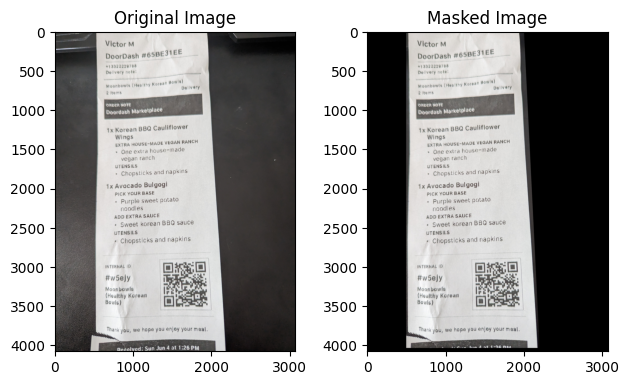

In [105]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Display the first image on the first subplot
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')

# Display the second image on the second subplot
ax2.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Masked Image')

# Remove ticks and labels from both subplots
ax1.axis('on')
ax2.axis('on')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()